<a href="https://colab.research.google.com/github/skylerlewis/tassajara/blob/main/tassajara_ndvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install packages

!pip install -q -U PyDrive
!pip install -q -U geemap

# get files from github

!wget https://github.com/skylerlewis/tassajara/raw/main/data/tassajara_perim.geojson

In [ ]:
# get API key from private google drive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def file_from_gdrive(filename, driveid):
    downloaded = drive.CreateFile({"id": driveid}) 
    downloaded.GetContentFile(filename)
    return filename

file_from_gdrive("tassajara-creek-e83f6fb39a0f.json", "1_BJV5EcePhqi_8Iwrreonng5-Q2JJXpz")

'tassajara-creek-e83f6fb39a0f.json'

In [3]:
# import packages

import ee
import geemap
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# authenticate with Google Earth Engine

service_account = "earth-engine@tassajara-creek.iam.gserviceaccount.com"
credentials = ee.ServiceAccountCredentials(service_account, 'tassajara-creek-e83f6fb39a0f.json')
ee.Initialize(credentials)

# https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb#scrollTo=v7pD6pDOAhOW
# first make a google cloud project with a service account and make sure you have access https://console.cloud.google.com/apis/credentials?project=tassajara-creek
# enable the API in cloud via https://console.cloud.google.com/apis/library/earthengine.googleapis.com?project=tassajara-creek
# then register the project via https://code.earthengine.google.com/register 

In [94]:
# import and map the area of interest

tassajara_perim = geemap.geojson_to_ee("tassajara_perim.geojson")
m = geemap.Map()
m.addLayer(tassajara_perim, {}, "perimeter")
m.centerObject(tassajara_perim, zoom=15)
m

Map(center=[37.707227929651516, -121.87901748917385], controls=(WidgetControl(options=['position', 'transparen…

In [36]:
# download NDVI data from Landsat 5, 7, and 8 for the area of interest

def applyScaleFactorsL5(image):
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0)
  return (image.addBands(opticalBands, None, True)
              .addBands(thermalBand, None, True))

def applyNdviL5(image):
  ndvi = ee.Image(image).normalizedDifference(['SR_B4', 'SR_B3'])
  return ee.Image(image).addBands(ndvi)

# get Landsat 5 through end of September 2013
landsat5 = (ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
    .filterBounds(tassajara_perim)
    .filterDate('1984-01-01', '2011-09-30')
    .filterMetadata('CLOUD_COVER_LAND', 'less_than', 20)
    .map(applyScaleFactorsL5)
    .map(applyNdviL5))

def applyScaleFactorsL7(image):
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0)
  return (image.addBands(opticalBands, None, True)
              .addBands(thermalBand, None, True))

# get Landsat 7 for just the interim period
landsat7 = (ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
    .filterBounds(tassajara_perim)
    .filterDate('2011-10-01', '2013-03-31')
    .filterMetadata('CLOUD_COVER_LAND', 'less_than', 20)
    .map(applyScaleFactorsL7)
    .map(applyNdviL5)) # can use same function as Landsat 5

def applyScaleFactorsL8(image):
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return (image.addBands(opticalBands, None, True)
              .addBands(thermalBands, None, True))

def applyNdviL8(image):
  ndvi = ee.Image(image).normalizedDifference(['SR_B5', 'SR_B4'])
  return ee.Image(image).addBands(ndvi)

# get Landsat 8 starting April 2013
landsat8 = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterBounds(tassajara_perim)
    .filterDate('2013-04-01', '2023-12-31')
    .filterMetadata('CLOUD_COVER_LAND', 'less_than', 20)
    .map(applyScaleFactorsL8)
    .map(applyNdviL8))

# merge all collections together

ndvi = landsat5.merge(landsat7).merge(landsat8).select('nd')

In [ ]:
# calculate the average NDVI within the AOI for each image in the collection

def setProperty(image):
    dict = image.reduceRegion(ee.Reducer.mean(), tassajara_perim)
    return image.set(dict)

# add the results to image properties
withMean = ndvi.map(setProperty)

In [ ]:
# extract the cloud-calculated NDVI means as a local Python list 

time = withMean.aggregate_array('system:time_start').getInfo()
ndvi = withMean.aggregate_array('nd').getInfo()

In [88]:
# consolidate as a data frame

ndvi_time_series = (
    pd.concat([pd.Series(time), pd.Series(ndvi)], axis=1, keys=["time", "ndvi"])
    .assign(time = lambda df: [pd.to_datetime(x * 1e6) for x in df["time"]])
    )
ndvi_time_series

,time,ndvi
0,1984-05-18 18:13:47.194000000,0.364794
1,1984-06-03 18:14:10.438000000,0.267640
2,1984-07-05 18:14:37.630000000,0.224809
3,1984-09-07 18:16:09.720000000,0.219606
4,1984-09-23 18:16:11.544000000,0.216027
...,...,...
448,2022-09-16 18:46:43.008000000,0.476842
449,2022-10-02 18:46:42.263000064,0.511270
450,2022-11-03 18:46:43.406000128,0.540508
451,2022-11-19 18:46:36.198000128,0.499110


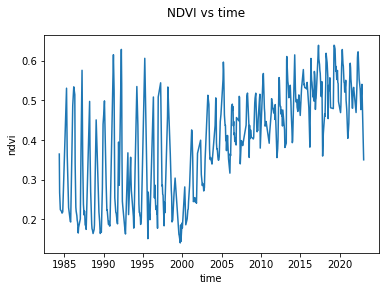

In [87]:
# plot the result

fig, ax = plt.subplots()
ax = sns.lineplot(data = ndvi_time_series, x="time", y="ndvi",
                  markers=True)
fig.suptitle("NDVI vs time")
plt.show()

In [95]:
# export the result to CSV

ndvi_time_series.to_csv("ndvi_time_series.csv")